# **Library**

In [ ]:
!pip install arabic_reshaper emoji transformers torch pandas scikit-learn tqdm numpy optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade transformers

# **Import**

In [ ]:
import json
import optuna
import pandas as pd
import numpy as np
import string
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from collections import Counter
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns
import xgboost as xgb
import joblib
from tqdm import tqdm
import re
import pickle
import json
#from arabic_reshaper import reshape
#import emoji
import warnings
import unicodedata
import random
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# **Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/validation.csv')

In [ ]:
print("Train Size:")
print(train_df.shape)
print("\nTest Size:")
print(test_df.shape)
print("\nValidation Size:")
print(val_df.shape)

Train Size:
(5960, 5)

Test Size:
(1278, 2)

Validation Size:
(1277, 2)


In [ ]:
# prompt: count the labels of emotion,offensive and hate in train_df

print("Emotion label counts:")
print(train_df['Emotion'].value_counts())
print("\nOffensive label counts:")
print(train_df['Offensive'].value_counts())
print("\nHate label counts:")
print(train_df['Hate'].value_counts())

Emotion label counts:
Emotion
anger           1551
disgust          777
neutral          661
love             593
joy              533
anticipation     491
optimism         419
sadness          335
confidence       210
pessimism        194
surprise         143
fear              53
Name: count, dtype: int64

Offensive label counts:
Offensive
no     4216
yes    1744
Name: count, dtype: int64

Hate label counts:
Hate
not_hate    1441
hate         303
Name: count, dtype: int64


In [ ]:
def count_non_arabic_chars(text):
    count = 0
    for char in text:
        # Check if the character is NOT within the Arabic Unicode range and is not a space or a digit
        if not ('\u0600' <= char <= '\u06FF' or char.isspace() or char.isdigit()):
            count += 1
    return count

train_df['non_arabic_char_count'] = train_df['text'].apply(count_non_arabic_chars)

print("Count of non-Arabic characters in each text entry:")
print(train_df[['text', 'non_arabic_char_count']].head())

print("\nTotal non-Arabic characters in the entire train_df:")
print(train_df['non_arabic_char_count'].sum())

Count of non-Arabic characters in each text entry:
                                                text  non_arabic_char_count
0  أحد التجار الشباب العمانيين يقول للاسف لما يكو...                     29
1  @JALHARBISKY مجموعه القدرة الجنسيه👍<LF> <LF>بد...                     94
2        @rwn4o حبيبييي والله اكثثثرر يارب امين🥺♥️♥️                     10
3  #وصال_دوت_FM<LF>مع سميرة الفطيسية @Samira_Alfu...                     93
4  من ينتزع ارواح اطفالنا من أجسادها بكل وحشية عل...                     36

Total non-Arabic characters in the entire train_df:
157138


In [ ]:
train_df.head(10)

,id,text,Emotion,Offensive,Hate,non_arabic_char_count,extracted_non_arabic_chars
0,2537,أحد التجار الشباب العمانيين يقول للاسف لما يكو...,neutral,no,NaN,29,!!<LF>.https://t.co/tBeNnETQz
1,5579,@JALHARBISKY مجموعه القدرة الجنسيه👍<LF> <LF>بد...,optimism,no,NaN,94,@JALHARBISKY👍<LF><LF>💞<LF>💞<LF>💞<LF><LF>💞<LF>💞...
2,6092,@rwn4o حبيبييي والله اكثثثرر يارب امين🥺♥️♥️,love,no,NaN,10,@rwno🥺♥️♥️
3,2540,#وصال_دوت_FM<LF>مع سميرة الفطيسية @Samira_Alfu...,neutral,no,NaN,93,#__FM<LF>@Samira_Alfutisi<LF><LF><LF>#__<LF><L...
4,3159,من ينتزع ارواح اطفالنا من أجسادها بكل وحشية عل...,anticipation,no,NaN,36,<LF><LF><LF>#_https://t.co/AFGQUXokG
5,5322,RT @6Basma6: مش هنسمح بشويه فاسده ان يجيبوا سي...,disgust,yes,not_hate,17,RT@Basma:<LF>#___
6,2457,#مصمم #ترويسه #رمزيات #شعارات<LF><LF> #اعلانات...,neutral,no,NaN,120,####<LF><LF>##_#<LF>@so_<LF>.<LF><LF><LF><LF><...
7,6826,قرت عينك الله لايحرمكم من بعض💚💚💚💚💚💚💚#رفعه_الصيعري,love,no,NaN,9,💚💚💚💚💚💚💚#_
8,7991,سيسي خاين..سيسي قاتل <LF>#هتافات_ثورية,anger,no,NaN,8,..<LF>#_
9,7051,مسيرات جمعة غضب القدس تتواصل في مختلف مناطق ال...,anger,yes,not_hate,56,-<LF><LF>##_<LF>#__<LF>###Bahrainhttps://t.co/...


In [ ]:
test_df['non_arabic_char_count'] = test_df['text'].apply(count_non_arabic_chars)

print("Count of non-Arabic characters in each text entry:")
print(test_df[['text', 'non_arabic_char_count']].head())

print("\nTotal non-Arabic characters in the entire test_df:")
print(test_df['non_arabic_char_count'].sum())

Count of non-Arabic characters in each text entry:
                                                text  non_arabic_char_count
0  @Hussain_HST اكله ما اتشرف بيك حبي شنو خاص ذيل...                     12
1  @Dr_abdoty من المتمسلمين..<LF><LF>جميع من سيها...                     31
2  ميناء بلحاف وحده كان يصدر من الغاز فقط ما طاقت...                     10
3  RT @llseenll: <LF><LF>خُذني إليكَ.. فَرُوحي تَ...                     35
4  دقيقه وجوالي ٢ يارب يارب يارب يارب الحق لاا جو...                     17

Total non-Arabic characters in the entire test_df:
32968


In [ ]:
val_df['non_arabic_char_count'] = val_df['text'].apply(count_non_arabic_chars)

print("Count of non-Arabic characters in each text entry:")
print(val_df[['text', 'non_arabic_char_count']].head())

print("\nTotal non-Arabic characters in the entire val_df:")
print(val_df['non_arabic_char_count'].sum())

Count of non-Arabic characters in each text entry:
                                                text  non_arabic_char_count
0  النيوك عندي مثل شرب الفناجيل #PS4share https:/...                     29
1  لن أتعاطف مع نادي بعض جمهوره الطقطقه عنده شتم ...                     22
2  يا ربي ايه الظلم ده😢<LF>ام لخمس اطفال تثتغيث<L...                     58
3  RT @4mm83: اعلام عار خايف من البلطجي مرتضي #فا...                     10
4  @puierq هو شوفي ع حسب بس انا كتجربه حبيت مره و...                      7

Total non-Arabic characters in the entire val_df:
32075


In [ ]:
import re

def extract_non_arabic_chars(text):
    non_arabic_chars = re.findall(r'[^\u0600-\u06FF\s\d]', text)
    return ''.join(non_arabic_chars)

train_df['extracted_non_arabic_chars'] = train_df['text'].apply(extract_non_arabic_chars)

print("Examples of extracted non-Arabic characters:")
for index, row in train_df.head(10).iterrows():
    print(f"Text: {row['text'][:50]}...") # Print first 50 chars of text
    print(f"Non-Arabic Chars: {row['extracted_non_arabic_chars']}")
    print("-" * 20)

# You can also see all unique non-Arabic characters in the dataset
all_non_arabic_chars = "".join(train_df['extracted_non_arabic_chars'].tolist())
unique_non_arabic_chars = "".join(sorted(list(set(all_non_arabic_chars))))
print("\nAll unique non-Arabic characters in the dataset:")
print(unique_non_arabic_chars)

Examples of extracted non-Arabic characters:
Text: أحد التجار الشباب العمانيين يقول للاسف لما يكون عن...
Non-Arabic Chars: !!<LF>.https://t.co/tBeNnETQz
--------------------
Text: @JALHARBISKY مجموعه القدرة الجنسيه👍<LF> <LF>بديل ا...
Non-Arabic Chars: @JALHARBISKY👍<LF><LF>💞<LF>💞<LF>💞<LF><LF>💞<LF>💞<LF>@<LF>💯<LF>@<LF>.📲<LF><LF>@Lina_ramal<LF>ISGf
--------------------
Text: @rwn4o حبيبييي والله اكثثثرر يارب امين🥺♥️♥️...
Non-Arabic Chars: @rwno🥺♥️♥️
--------------------
Text: #وصال_دوت_FM<LF>مع سميرة الفطيسية @Samira_Alfutisi...
Non-Arabic Chars: #__FM<LF>@Samira_Alfutisi<LF><LF><LF>#__<LF><LF>🎞|@ALBusaidiAmr<LF><LF>https://t.co/WubcxZNuX
--------------------
Text: من ينتزع ارواح اطفالنا من أجسادها بكل وحشية عليه ا...
Non-Arabic Chars: <LF><LF><LF>#_https://t.co/AFGQUXokG
--------------------
Text: RT @6Basma6: مش هنسمح بشويه فاسده ان يجيبوا سيره ن...
Non-Arabic Chars: RT@Basma:<LF>#___
--------------------
Text: #مصمم #ترويسه #رمزيات #شعارات<LF><LF> #اعلانات #ال...
Non-Arabic Chars: ####<

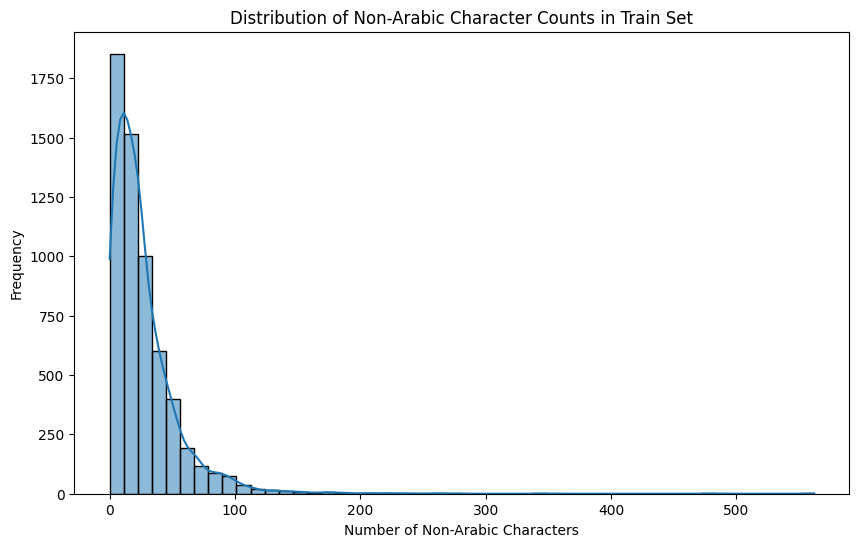

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of the non-Arabic character counts
plt.figure(figsize=(10, 6))
sns.histplot(train_df['non_arabic_char_count'], bins=50, kde=True)
plt.title('Distribution of Non-Arabic Character Counts in Train Set')
plt.xlabel('Number of Non-Arabic Characters')
plt.ylabel('Frequency')
plt.show()

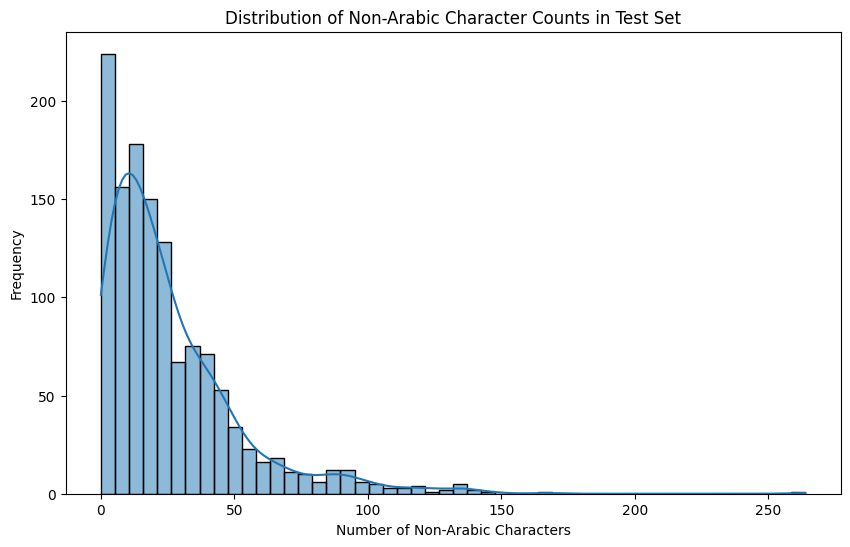

In [ ]:
# Plot a histogram of the non-Arabic character counts
plt.figure(figsize=(10, 6))
sns.histplot(test_df['non_arabic_char_count'], bins=50, kde=True)
plt.title('Distribution of Non-Arabic Character Counts in Test Set')
plt.xlabel('Number of Non-Arabic Characters')
plt.ylabel('Frequency')
plt.show()

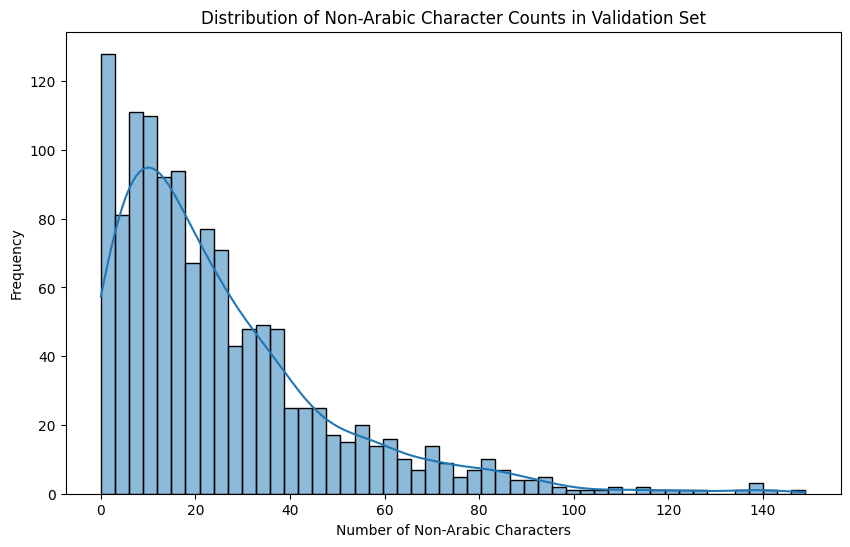

In [ ]:
# Plot a histogram of the non-Arabic character counts
plt.figure(figsize=(10, 6))
sns.histplot(val_df['non_arabic_char_count'], bins=50, kde=True)
plt.title('Distribution of Non-Arabic Character Counts in Validation Set')
plt.xlabel('Number of Non-Arabic Characters')
plt.ylabel('Frequency')
plt.show()

In [ ]:
train_df.head(10)

,id,text,Emotion,Offensive,Hate,non_arabic_char_count,extracted_non_arabic_chars
0,2537,أحد التجار الشباب العمانيين يقول للاسف لما يكو...,neutral,no,NaN,29,!!<LF>.https://t.co/tBeNnETQz
1,5579,@JALHARBISKY مجموعه القدرة الجنسيه👍<LF> <LF>بد...,optimism,no,NaN,94,@JALHARBISKY👍<LF><LF>💞<LF>💞<LF>💞<LF><LF>💞<LF>💞...
2,6092,@rwn4o حبيبييي والله اكثثثرر يارب امين🥺♥️♥️,love,no,NaN,10,@rwno🥺♥️♥️
3,2540,#وصال_دوت_FM<LF>مع سميرة الفطيسية @Samira_Alfu...,neutral,no,NaN,93,#__FM<LF>@Samira_Alfutisi<LF><LF><LF>#__<LF><L...
4,3159,من ينتزع ارواح اطفالنا من أجسادها بكل وحشية عل...,anticipation,no,NaN,36,<LF><LF><LF>#_https://t.co/AFGQUXokG
5,5322,RT @6Basma6: مش هنسمح بشويه فاسده ان يجيبوا سي...,disgust,yes,not_hate,17,RT@Basma:<LF>#___
6,2457,#مصمم #ترويسه #رمزيات #شعارات<LF><LF> #اعلانات...,neutral,no,NaN,120,####<LF><LF>##_#<LF>@so_<LF>.<LF><LF><LF><LF><...
7,6826,قرت عينك الله لايحرمكم من بعض💚💚💚💚💚💚💚#رفعه_الصيعري,love,no,NaN,9,💚💚💚💚💚💚💚#_
8,7991,سيسي خاين..سيسي قاتل <LF>#هتافات_ثورية,anger,no,NaN,8,..<LF>#_
9,7051,مسيرات جمعة غضب القدس تتواصل في مختلف مناطق ال...,anger,yes,not_hate,56,-<LF><LF>##_<LF>#__<LF>###Bahrainhttps://t.co/...


# **Preprocessing and Cleaning**

In [ ]:
arabic_punctuations = '''`÷« »×؛<>٩٨'٧٦٥٤٣٢١٠_()↗*•&^%][ـ،/:"؟.,'{}⋮≈~¦+|٪!”…“–ـ/[]%=#*+\•~@£·_{}©^®`→°€™›♥←×§″′Â█à…“★”–●â►−¢¬░¶↑±▾	═¦║―¥▓—‹─▒：⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡₹´'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [ ]:
def remove_diacritics(df):
    df['text'] = df['text'].apply(lambda x: _remove_diacritics(x))
    return df
def _remove_diacritics(x):
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(df):
    df['text'] = df['text'].apply(lambda x: _normalize_arabic(x))
    return df
def _normalize_arabic(x):
    x = str(x)
    # added space around puncts after replace
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)
    return x

def remove_punctuations(df):
    df['text'] = df['text'].apply(lambda x: _remove_punctuations(x))
    return df
def _remove_punctuations(x):
    x = str(x)
    #translator = str.maketrans(' ', ' ', punctuations_list)
    translator = str.maketrans(punctuations_list, ' '*len(punctuations_list))
    return x.translate(translator)

def remove_repeating_char(df):
    df['text'] = df['text'].apply(lambda x: _remove_repeating_char(x))
    return df
def _remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)

def remove_english_word_and_numbers(df):
    df['text'] = df['text'].apply(lambda x: _remove_english_word_and_numbers(x))
    return df
def _remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

def clean_space(df):
    compiled_re = re.compile(r"\s+")
    df['text'] = df["text"].apply(lambda x: _clean_space(x, compiled_re))
    return df
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)

In [ ]:
def clean(df):
    df = remove_diacritics(df)
    df = normalize_arabic(df)
    df = remove_punctuations(df)
    df = remove_repeating_char(df)
    df= remove_english_word_and_numbers(df)
    df=clean_space(df)
    return df


In [ ]:
num_cores = 2
def df_parallelize_run(df, func, num_cores=2):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


In [ ]:
train_df = df_parallelize_run(train_df, clean)
test_df = df_parallelize_run(test_df, clean)
val_df = df_parallelize_run(val_df, clean)

In [ ]:
train_df.head(10)

,id,text,img_path,hate_label,non_arabic_char_count
0,data/arabic_memes_fb_insta_pinterest/Pinterest...,زوجه ماكرون تصرح ان الحجاب يرعب ويخيف الاطفال 😅😂,./data/arabic_memes_fb_insta_pinterest/Pintere...,0,5
1,data/arabic_memes_fb_insta_pinterest/Pinterest...,ده حال الادمن لمابنت تشتكيله من عضو دايقها ء,./data/arabic_memes_fb_insta_pinterest/Pintere...,0,4
2,data/arabic_memes_fb_insta_pinterest/Pinterest...,سما الصدي عاوزه اتجوز محمد صلاح شهر واحد وهيبق...,./data/arabic_memes_fb_insta_pinterest/Pintere...,0,3
3,data/arabic_memes_fb_insta_pinterest/Instagram...,اما بابا يصحي الفجر ويلاقينا انا وماما واختي ل...,./data/arabic_memes_fb_insta_pinterest/Instagr...,0,0
4,data/arabic_memes_fb_insta_pinterest/Facebook/...,بم معربه معزن ولرانبه طب واله العظيم لاحلق شعر...,./data/arabic_memes_fb_insta_pinterest/Faceboo...,0,0
5,data/arabic_memes_fb_insta_pinterest/Pinterest...,كل سنه وانتي معايا قلت الكلام د لكام واحده قبل...,./data/arabic_memes_fb_insta_pinterest/Pintere...,0,0
6,data/arabic_memes_fb_insta_pinterest/Instagram...,ما كوريا الشماليه تعلن عن اكتشا فها العربيه ع...,./data/arabic_memes_fb_insta_pinterest/Instagr...,0,4
7,data/arabic_memes_fb_insta_pinterest/Instagram...,الي زوجتي المستقبليه ساجعلك تزورين هذا القسم ك...,./data/arabic_memes_fb_insta_pinterest/Instagr...,1,2
8,data/arabic_memes_fb_insta_pinterest/Instagram...,يابنتي لازم تبقي تقيله ومتبينيش انك بتكراش علي...,./data/arabic_memes_fb_insta_pinterest/Instagr...,0,5
9,data/arabic_memes_fb_insta_pinterest/Instagram...,لما تلاقي الشير والستوري بعد الخناقه بدقيقه ان...,./data/arabic_memes_fb_insta_pinterest/Instagr...,0,1


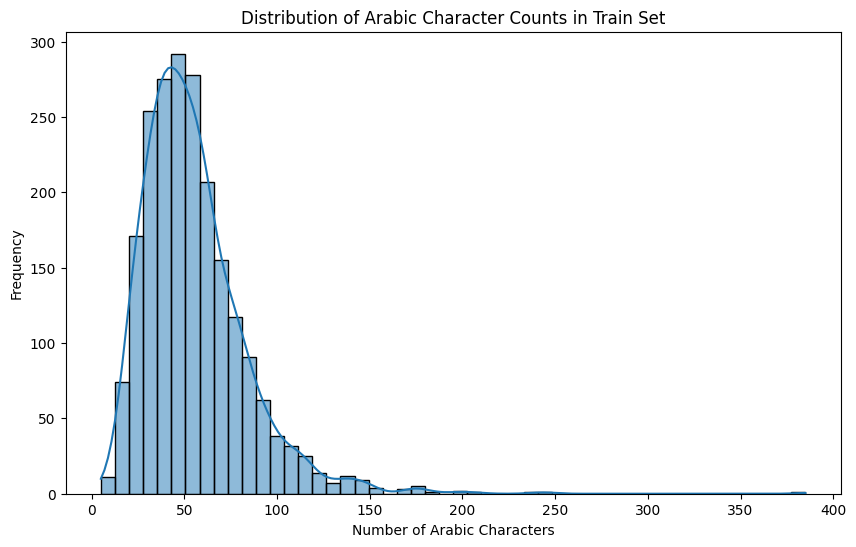

In [ ]:
def count_arabic_chars(text):
    count = 0
    for char in text:
        if '\u0600' <= char <= '\u06FF':
            count += 1
    return count

train_df['arabic_char_count'] = train_df['text'].apply(count_arabic_chars)

plt.figure(figsize=(10, 6))
sns.histplot(train_df['arabic_char_count'], bins=50, kde=True)
plt.title('Distribution of Arabic Character Counts in Train Set')
plt.xlabel('Number of Arabic Characters')
plt.ylabel('Frequency')
plt.show()

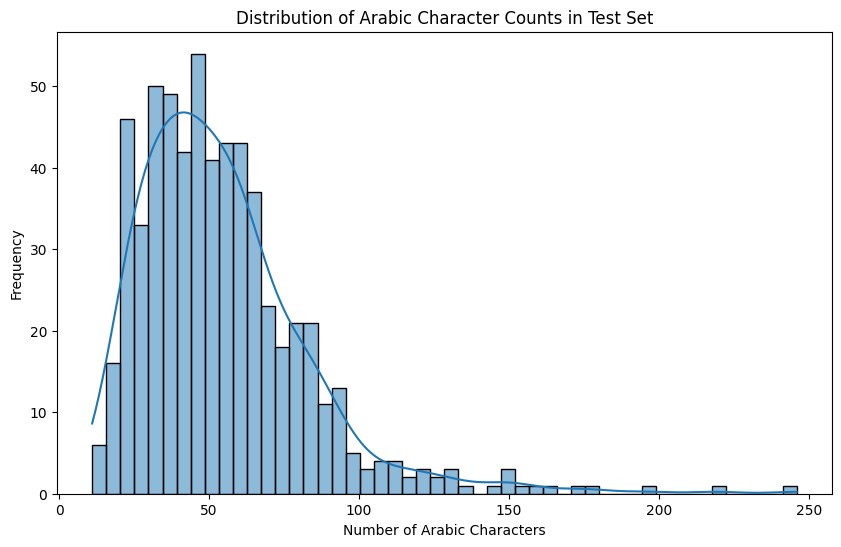

In [ ]:
test_df['arabic_char_count'] = test_df['text'].apply(count_arabic_chars)

plt.figure(figsize=(10, 6))
sns.histplot(test_df['arabic_char_count'], bins=50, kde=True)
plt.title('Distribution of Arabic Character Counts in Test Set')
plt.xlabel('Number of Arabic Characters')
plt.ylabel('Frequency')
plt.show()

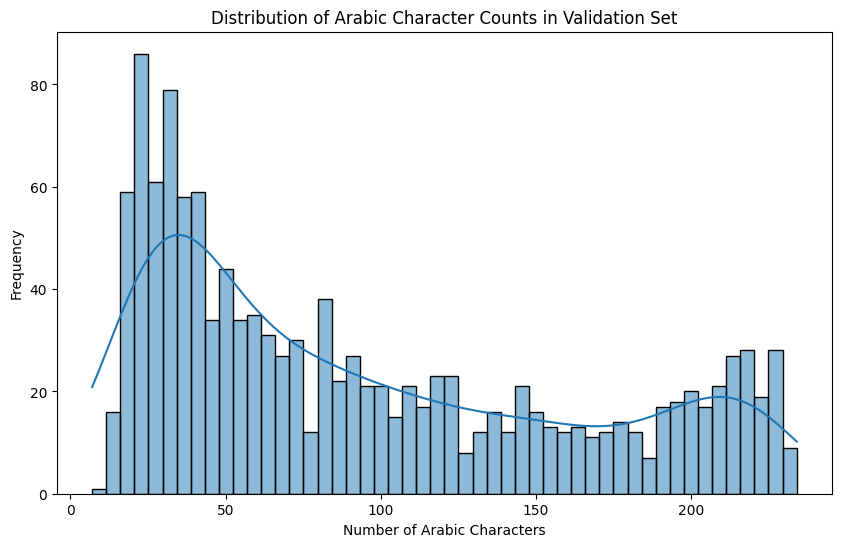

In [ ]:
val_df['arabic_char_count'] = val_df['text'].apply(count_arabic_chars)

plt.figure(figsize=(10, 6))
sns.histplot(val_df['arabic_char_count'], bins=50, kde=True)
plt.title('Distribution of Arabic Character Counts in Validation Set')
plt.xlabel('Number of Arabic Characters')
plt.ylabel('Frequency')
plt.show()

In [ ]:
train_df = train_df.dropna(subset=['text'])

In [ ]:
train_df['Emotion'] = train_df['Emotion'].fillna('neutral')
train_df['Offensive'] = train_df['Offensive'].fillna('no')
train_df['Hate'] = train_df['Hate'].fillna('not_hate')

In [ ]:
# Save metrics to JSON
def save_metrics(metrics, filename='/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/classification_metrics_xgb_araBert+xlmRoberta_trial_weight.json'):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(metrics, f, ensure_ascii=False, indent=4)

# **XGBoosting**

In [ ]:
# Fuse AraBERT and XLM-RoBERTa embeddings
def get_fused_embeddings(texts, arabert_tokenizer, arabert_model, xlmroberta_tokenizer, xlmroberta_model, device='cpu'):
    print("Extracting AraBERT embeddings...")
    arabert_embeddings = get_embeddings(texts, arabert_tokenizer, arabert_model, device)
    print("Extracting XLM-RoBERTa embeddings...")
    xlmroberta_embeddings = get_embeddings(texts, xlmroberta_tokenizer, xlmroberta_model, device)
    # Concatenate embeddings
    fused_embeddings = np.concatenate([arabert_embeddings, xlmroberta_embeddings], axis=1)
    return fused_embeddings

In [ ]:
# Extract AraBERT embeddings
def get_embeddings(texts, tokenizer, model, device='cpu', batch_size=16):
    model.to(device)
    model.eval()
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
      batch_texts = texts[i:i + batch_size]
      inputs = tokenizer(batch_texts, return_tensors='pt', max_length=128,
                         truncation=True, padding=True).to(device)

      with torch.no_grad():
        outputs = model(**inputs)
        # Extract [CLS] token embeddings (first token of last hidden layer)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)

    return np.vstack(embeddings)

In [ ]:
# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(train_df['text'])

In [ ]:
# Initialize AraBERT tokenizer and model
#tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02')
arabert_tokenizer = joblib.load('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/arabert_tokenizer.joblib')
arabert_model = AutoModel.from_pretrained('aubmindlab/bert-base-arabertv02', from_tf=False)
#xlmroberta_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
xlmroberta_tokenizer = joblib.load('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/xlmroberta_tokenizer.joblib')
xlmroberta_model = AutoModel.from_pretrained('xlm-roberta-base', from_tf=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Extract Fused embeddings
X = get_fused_embeddings(train_df['text'].tolist(), arabert_tokenizer, arabert_model,
                            xlmroberta_tokenizer, xlmroberta_model, device)

# Save tokenizer
joblib.dump(arabert_tokenizer, '/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/arabert_tokenizer.joblib')
joblib.dump(xlmroberta_tokenizer, '/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/xlmroberta_tokenizer.joblib')

# Save Fused embeddings
np.save('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/fused_embeddings.npy', X)

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Extracting AraBERT embeddings...


Extracting embeddings: 100%|██████████| 373/373 [15:32<00:00,  2.50s/it]


Extracting XLM-RoBERTa embeddings...


Extracting embeddings: 100%|██████████| 373/373 [19:29<00:00,  3.13s/it]


In [ ]:
# # Compute class weights for Emotion to handle imbalance
# def compute_class_weights(y):
#     unique, counts = np.unique(y, return_counts=True)
#     weights = {i: max(counts) / count for i, count in zip(unique, counts)}
#     return weights

# Compute class weights for multiclass tasks
def compute_class_weights(y, num_classes):
    counts = np.bincount(y, minlength=num_classes)
    weights = 1.0 / (counts + 1e-6)  # Avoid division by zero
    weights = weights / weights.sum() * num_classes  # Normalize
    return torch.tensor(weights, dtype=torch.float32)

# Compute scale_pos_weight for binary tasks
def compute_scale_pos_weight(y):
    neg_count = np.sum(y == 0)
    pos_count = np.sum(y == 1)
    return neg_count / pos_count if pos_count > 0 else 1.0

In [ ]:
# Load fused embeddings
X = np.load('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/fused_embeddings.npy')

# Encode labels
emotion_encoder = LabelEncoder()
offensive_encoder = LabelEncoder()
hate_encoder = LabelEncoder()

# Encode labels
y_emotion = emotion_encoder.fit_transform(train_df['Emotion'])
y_offensive = offensive_encoder.fit_transform(train_df['Offensive'])
y_hate = hate_encoder.fit_transform(train_df['Hate'])

# Get original indices
original_indices = np.arange(len(train_df))

# Split data: 80% train, 10% val, 10% test using a single train_test_split call
# First split: 10% test, 90% train+val
# Within train+val (90%), split into 8/9 train (~80% of total), 1/9 val (~10% of total)
# train_test_split can handle this with appropriate test_size and train_size
X_train, X_temp, y_emotion_train, y_emotion_temp, train_indices, temp_indices = train_test_split(
        X, y_emotion, original_indices, test_size=0.2, train_size=0.8, random_state=42, stratify=y_emotion)
X_val, X_test, y_emotion_val, y_emotion_test, val_indices, test_indices = train_test_split(
        X_temp, y_emotion_temp, temp_indices, test_size=0.5, random_state=42, stratify=y_emotion_temp)

X_train_off, X_temp_off, y_offensive_train, y_offensive_temp, _, _ = train_test_split(
        X, y_offensive, original_indices, test_size=0.2, train_size=0.8, random_state=42, stratify=y_offensive)
X_val_off, X_test_off, y_offensive_val, y_offensive_test, _, _ = train_test_split(
        X_temp_off, y_offensive_temp, temp_indices, test_size=0.5, random_state=42, stratify=y_offensive_temp)

X_train_hate, X_temp_hate, y_hate_train, y_hate_temp, _, _ = train_test_split(
        X, y_hate, original_indices, test_size=0.2, train_size=0.8, random_state=42, stratify=y_hate)
X_val_hate, X_test_hate, y_hate_val, y_hate_test, _, _ = train_test_split(
        X_temp_hate, y_hate_temp, temp_indices, test_size=0.5, random_state=42, stratify=y_hate_temp)

# Verify split proportions
total_samples = len(X)
print(f"Total samples: {total_samples}")
print(f"Emotion - Train: {len(X_train)} ({len(X_train)/total_samples:.2%}), "
      f"Val: {len(X_val)} ({len(X_val)/total_samples:.2%}), "
      f"Test: {len(X_test)} ({len(X_test)/total_samples:.2%})")

Total samples: 5960
Emotion - Train: 4768 (80.00%), Val: 596 (10.00%), Test: 596 (10.00%)


In [ ]:
# Train and evaluate a single XGBoost model
def train_and_evaluate(X_train, X_val, X_test, y_train, y_val, y_test, target, label_encoder, num_classes, is_multiclass=False, device='cpu'):
    def objective(trial):
        params = {
            'objective': 'multi:softmax' if is_multiclass else 'binary:logistic',
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': 42
        }
        if is_multiclass:
            params['num_class'] = len(label_encoder.classes_)
        if not is_multiclass:
            params['scale_pos_weight'] = compute_scale_pos_weight(y_train)

        model = xgb.XGBClassifier(**params)
        sample_weights = None
        if is_multiclass:
            weights_tensor = compute_class_weights(y_train, num_classes)
            weights = {i: w.item() for i, w in enumerate(weights_tensor)}
            sample_weights = [weights.get(y, 1.0) for y in y_train]

        model.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = model.predict(X_test)
        return f1_score(y_test, y_pred, average='macro')

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=5)  # Adjust n_trials for more thorough tuning

    # Train final model with best parameters
    best_params = study.best_params
    best_params['random_state'] = 42
    if is_multiclass:
        best_params['num_class'] = len(label_encoder.classes_)
        best_params['objective'] = 'multi:softmax'
    else:
        best_params['objective'] = 'binary:logistic'
        best_params['scale_pos_weight'] = compute_scale_pos_weight(y_train)

    xgb_model = xgb.XGBClassifier(**best_params)
    sample_weights = None
    if is_multiclass:
        weights_tensor = compute_class_weights(y_train, num_classes)
        weights = {i: w.item() for i, w in enumerate(weights_tensor)}
        sample_weights = [weights.get(y, 1.0) for y in y_train]

    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

    # Save model
    joblib.dump(xgb_model, f'{target.lower()}_model.joblib')

    # Predict and evaluate
    y_pred = xgb_model.predict(X_test)

    # Compute metrics
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    macro_acc = accuracy_score(y_test, y_pred)

    print(f"Best parameters for {target}: {best_params}")


    # # Convert data to PyTorch tensors
    # X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    # X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    # X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    # y_train_tensor = torch.tensor(y_train, dtype=torch.long if num_classes > 1 else torch.float32).to(device)
    # y_val_tensor = torch.tensor(y_val, dtype=torch.long if num_classes > 1 else torch.float32).to(device)
    # y_test_tensor = torch.tensor(y_test, dtype=torch.long if num_classes > 1 else torch.float32).to(device)

    # # Create DataLoaders
    # train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    # val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # # Initialize model
    # input_dim = X_train.shape[1]  # 1536 (fused embeddings)
    # model = TextClassifier(input_dim=input_dim, hidden_dim1=256, hidden_dim2=128, output_dim=num_classes).to(device)
    # class_weights = compute_class_weights(y_train, num_classes).to(device)
    # # Loss and optimizer
    # if num_classes > 1:  # Multiclass
    #     criterion = nn.CrossEntropyLoss(weight=class_weights)
    # else:  # Binary
    #     pos_weight = class_weights[1] / class_weights[0] if class_weights[0] > 0 else 1.0
    #     criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # # Early stopping variables
    # best_val_loss = float('inf')
    # best_model_path = f'{target.lower()}_model_best.pt'
    # patience_counter = 0
    # early_stopping_epoch = None

    # # Train model and track losses
    # train_losses = []
    # val_losses = []
    # model.train()
    # for epoch in tqdm(range(epochs), desc=f"Training {target}"):
    #     train_loss = 0.0
    #     for X_batch, y_batch in train_loader:
    #         optimizer.zero_grad()
    #         outputs = model(X_batch)
    #         if num_classes == 1:  # Binary
    #             outputs = outputs.squeeze()
    #         loss = criterion(outputs, y_batch)
    #         loss.backward()
    #         optimizer.step()
    #         train_loss += loss.item() * X_batch.size(0)
    #     train_loss /= len(train_loader.dataset)
    #     train_losses.append(train_loss)

    #     # Validation loss
    #     model.eval()
    #     val_loss = 0.0
    #     with torch.no_grad():
    #         for X_batch, y_batch in val_loader:
    #             outputs = model(X_batch)
    #             if num_classes == 1:  # Binary
    #                 outputs = outputs.squeeze()
    #             loss = criterion(outputs, y_batch)
    #             val_loss += loss.item() * X_batch.size(0)
    #         val_loss /= len(val_loader.dataset)
    #         val_losses.append(val_loss)

    #     # Print losses for this epoch
    #     print(f"Epoch {epoch+1}/{epochs} - {target} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    #     # Early stopping check
    #     if val_loss < best_val_loss:
    #         best_val_loss = val_loss
    #         #torch.save(model.state_dict(), best_model_path)
    #         patience_counter = 0
    #     else:
    #         patience_counter += 1
    #         if patience_counter >= patience:
    #             early_stopping_epoch = epoch + 1
    #             print(f"Early stopping triggered at epoch {early_stopping_epoch} for {target}")
    #             break

    #     model.train()
    #     scheduler.step()

    # # Save the final model
    # torch.save(model.state_dict(), best_model_path)

    # # Evaluate on test set using the best model
    # model.load_state_dict(torch.load(best_model_path))
    # model.eval()
    # with torch.no_grad():
    #     outputs = model(X_test_tensor)
    #     if num_classes > 1:  # Multiclass
    #         _, y_pred = torch.max(outputs, dim=1)
    #     else:  # Binary
    #         y_pred = (torch.sigmoid(outputs).squeeze() > 0.5).long()
    #     y_pred = y_pred.cpu().numpy()
    #     y_test = y_test_tensor.cpu().numpy()

    # # Compute metrics
    # macro_f1 = f1_score(y_test, y_pred, average='macro')
    # macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    # macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    # macro_acc = accuracy_score(y_test, y_pred)

    return {
        'macro_average_f1_score': float(macro_f1),
        'macro_average_accuracy': float(macro_acc),
        'macro_average_precision': float(macro_precision),
        'macro_average_recall': float(macro_recall)
        # 'train_losses': [float(loss) for loss in train_losses],
        # 'val_losses': [float(loss) for loss in val_losses],
        # 'early_stopping_epoch': early_stopping_epoch if early_stopping_epoch else epochs
    }

In [ ]:
# Train and evaluate models
metrics = {}

# Emotion model
# metrics['Emotion'] = train_and_evaluate(
#         X_train, X_test, y_emotion_train, y_emotion_test, 'Emotion_araBert+xlmRoberta_weight',
#         emotion_encoder, is_multiclass=True)
metrics['Emotion'] = train_and_evaluate(
        X_train, X_val, X_test, y_emotion_train, y_emotion_val, y_emotion_test,
        'Emotion_trial', emotion_encoder, num_classes=len(emotion_encoder.classes_), is_multiclass=True, device=device)
print("\nResults for Emotion:")
print(f"Macro-average F1-score: {metrics['Emotion']['macro_average_f1_score']:.4f}")
print(f"Macro-average Accuracy: {metrics['Emotion']['macro_average_accuracy']:.4f}")
print(f"Macro-average Precision: {metrics['Emotion']['macro_average_precision']:.4f}")
print(f"Macro-average Recall: {metrics['Emotion']['macro_average_recall']:.4f}")
print(f"Training Losses: {[round(loss, 4) for loss in metrics['Emotion']['train_losses']]}")
print(f"Validation Losses: {[round(loss, 4) for loss in metrics['Emotion']['val_losses']]}")
print(f"Early Stopping Epoch: {metrics['Emotion']['early_stopping_epoch']}")

[I 2025-07-30 09:13:55,054] A new study created in memory with name: no-name-cc2b355a-66a2-4e90-9fcb-121c985d3efa
[I 2025-07-30 09:37:27,680] Trial 0 finished with value: 0.31022642674071144 and parameters: {'learning_rate': 0.001940771047280699, 'max_depth': 9, 'n_estimators': 251, 'subsample': 0.9910653573549056, 'colsample_bytree': 0.7745612515600351}. Best is trial 0 with value: 0.31022642674071144.
[I 2025-07-30 09:42:17,915] Trial 1 finished with value: 0.31303055425770504 and parameters: {'learning_rate': 0.005664461765401038, 'max_depth': 6, 'n_estimators': 84, 'subsample': 0.8922083610398939, 'colsample_bytree': 0.9390744211247125}. Best is trial 1 with value: 0.31303055425770504.
[I 2025-07-30 09:46:54,391] Trial 2 finished with value: 0.3241177035515945 and parameters: {'learning_rate': 0.006047805802808347, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.9453141618352463, 'colsample_bytree': 0.7365842563192598}. Best is trial 2 with value: 0.3241177035515945.
[I 2025-07

Best parameters for Emotion_trial: {'learning_rate': 0.006047805802808347, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.9453141618352463, 'colsample_bytree': 0.7365842563192598, 'random_state': 42, 'num_class': 12, 'objective': 'multi:softmax'}

Results for Emotion:
Macro-average F1-score: 0.3241
Macro-average Accuracy: 0.4614
Macro-average Precision: 0.3336
Macro-average Recall: 0.3349


KeyError: 'train_losses'

In [ ]:
# Preprocess the test_df
test_df_cleaned = df_parallelize_run(test_df.copy(), clean)

# Extract embeddings for the cleaned test_df
# X_test_df = get_fused_embeddings(test_df_cleaned['text'].tolist(), arabert_tokenizer, arabert_model,
#                                 xlmroberta_tokenizer, xlmroberta_model, device)

# Load the saved model
emotion_model = joblib.load('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/emotion_trial_model.joblib')

# Predict on the preprocessed test_df
y_pred_test_df = emotion_model.predict(X_test_df)

# Create a new DataFrame with the IDs, text, and the predictions
predictions_test_df = pd.DataFrame({
    'id': test_df['id'].values,
    'Emotion_Predicted': emotion_encoder.inverse_transform(y_pred_test_df)
})

# Save the predictions to a CSV file
predictions_test_df.to_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_emotion_predictions.csv', index=False)

print("Predictions for test_df saved to /content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_emotion_predictions.csv")
display(predictions_test_df.head())

Predictions for test_df saved to /content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_emotion_predictions.csv


,id,Emotion_Predicted
0,7775,love
1,6675,anger
2,5493,anger
3,7191,love
4,3206,sadness


In [ ]:
 # Offensive model
# metrics['Offensive'] = train_and_evaluate(
#         X_train, X_test, y_offensive_train, y_offensive_test, 'Offensive_araBert+xlmRoberta_weight',
#         offensive_encoder, is_multiclass=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
metrics['Offensive'] = train_and_evaluate(
        X_train_off, X_val_off, X_test_off, y_offensive_train, y_offensive_val, y_offensive_test,
        'Offensive_trial', offensive_encoder, num_classes=1, is_multiclass=False, device=device)
print("\nResults for Offensive:")
print(f"Macro-average F1-score: {metrics['Offensive']['macro_average_f1_score']:.4f}")
print(f"Macro-average Accuracy: {metrics['Offensive']['macro_average_accuracy']:.4f}")
print(f"Macro-average Precision: {metrics['Offensive']['macro_average_precision']:.4f}")
print(f"Macro-average Recall: {metrics['Offensive']['macro_average_recall']:.4f}")
# print(f"Training Losses: {[round(loss, 4) for loss in metrics['Offensive']['train_losses']]}")
# print(f"Validation Losses: {[round(loss, 4) for loss in metrics['Offensive']['val_losses']]}")
# print(f"Early Stopping Epoch: {metrics['Offensive']['early_stopping_epoch']}")

[I 2025-08-04 07:24:53,780] A new study created in memory with name: no-name-b8e6a2f6-de04-4aeb-8966-542241e76e3e
[I 2025-08-04 07:25:20,895] Trial 0 finished with value: 0.7657863386709987 and parameters: {'learning_rate': 0.001716006077188985, 'max_depth': 4, 'n_estimators': 115, 'subsample': 0.840726122988293, 'colsample_bytree': 0.9691273458951862}. Best is trial 0 with value: 0.7657863386709987.
[I 2025-08-04 07:26:10,446] Trial 1 finished with value: 0.7636796193497224 and parameters: {'learning_rate': 0.0011160606408814008, 'max_depth': 4, 'n_estimators': 264, 'subsample': 0.6263410836262121, 'colsample_bytree': 0.6120434636958537}. Best is trial 0 with value: 0.7657863386709987.
[I 2025-08-04 07:27:29,381] Trial 2 finished with value: 0.7768894979950256 and parameters: {'learning_rate': 0.007049510152846402, 'max_depth': 6, 'n_estimators': 145, 'subsample': 0.9658474806676403, 'colsample_bytree': 0.8224060037116377}. Best is trial 2 with value: 0.7768894979950256.
[I 2025-08-04

Best parameters for Offensive_trial: {'learning_rate': 0.0010617671493631567, 'max_depth': 7, 'n_estimators': 282, 'subsample': 0.8231208303423814, 'colsample_bytree': 0.6489399577042816, 'random_state': 42, 'objective': 'binary:logistic', 'scale_pos_weight': np.float64(2.417921146953405)}


NameError: name 'metrics' is not defined

In [ ]:
# Load the saved offensive model
offensive_model = joblib.load('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/offensive_trial_model.joblib')

# Predict on the preprocessed test_df
y_pred_offensive_test_df = offensive_model.predict(X_test_df)

# Create a new DataFrame with the IDs and the predictions
predictions_test_df_offensive = pd.DataFrame({
    'id': test_df['id'].values,
    'Offensive_Predicted': offensive_encoder.inverse_transform(y_pred_offensive_test_df)
})

# Save the predictions to a CSV file
predictions_test_df_offensive.to_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_offensive_predictions.csv', index=False)

print("Predictions for test_df saved to /content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_offensive_predictions.csv")
display(predictions_test_df_offensive.head())

Predictions for test_df saved to /content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_offensive_predictions.csv


,id,Offensive_Predicted
0,7775,no
1,6675,yes
2,5493,yes
3,7191,no
4,3206,no


In [ ]:
 # Hate model
# metrics['Hate'] = train_and_evaluate(
#         X_train, X_test, y_hate_train, y_hate_test, 'Hate_araBert+xlmRoberta_weight',
#         hate_encoder, is_multiclass=True)

metrics['Hate'] = train_and_evaluate(
        X_train_hate, X_val_hate, X_test_hate, y_hate_train, y_hate_val, y_hate_test,
        'Hate_trial', hate_encoder, num_classes=1, is_multiclass=False, device=device)
print("\nResults for Hate:")
print(f"Macro-average F1-score: {metrics['Hate']['macro_average_f1_score']:.4f}")
print(f"Macro-average Accuracy: {metrics['Hate']['macro_average_accuracy']:.4f}")
print(f"Macro-average Precision: {metrics['Hate']['macro_average_precision']:.4f}")
print(f"Macro-average Recall: {metrics['Hate']['macro_average_recall']:.4f}")
# print(f"Training Losses: {[round(loss, 4) for loss in metrics['Hate']['train_losses']]}")
# print(f"Validation Losses: {[round(loss, 4) for loss in metrics['Hate']['val_losses']]}")
# print(f"Early Stopping Epoch: {metrics['Hate']['early_stopping_epoch']}")

[I 2025-07-30 10:20:43,865] A new study created in memory with name: no-name-233c90ee-1b21-49f6-b25b-3d776af77cfa
[I 2025-07-30 10:21:04,891] Trial 0 finished with value: 0.5715530787386046 and parameters: {'learning_rate': 0.004704816953636987, 'max_depth': 4, 'n_estimators': 163, 'subsample': 0.8036927070085966, 'colsample_bytree': 0.8169010069883762}. Best is trial 0 with value: 0.5715530787386046.
[I 2025-07-30 10:21:55,406] Trial 1 finished with value: 0.6236108491146342 and parameters: {'learning_rate': 0.0024558664428429413, 'max_depth': 8, 'n_estimators': 236, 'subsample': 0.6748535287355293, 'colsample_bytree': 0.803995574391982}. Best is trial 1 with value: 0.6236108491146342.
[I 2025-07-30 10:22:14,933] Trial 2 finished with value: 0.6012115892395911 and parameters: {'learning_rate': 0.003654490190958893, 'max_depth': 6, 'n_estimators': 94, 'subsample': 0.7117875766646461, 'colsample_bytree': 0.8239121501384533}. Best is trial 1 with value: 0.6236108491146342.
[I 2025-07-30 

Best parameters for Hate_trial: {'learning_rate': 0.0036614733406959395, 'max_depth': 10, 'n_estimators': 182, 'subsample': 0.7523724733123648, 'colsample_bytree': 0.8440185670346704, 'random_state': 42, 'objective': 'binary:logistic', 'scale_pos_weight': np.float64(0.053468846663720725)}

Results for Hate:
Macro-average F1-score: 0.6294
Macro-average Accuracy: 0.8758
Macro-average Precision: 0.6014
Macro-average Recall: 0.7363


KeyError: 'train_losses'

In [ ]:
# Load the saved hate model
hate_model = joblib.load('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/hate_trial_model.joblib')

# Predict on the preprocessed test_df
y_pred_hate_test_df = hate_model.predict(X_test_df)

# Create a new DataFrame with the IDs and the predictions
predictions_test_df_hate = pd.DataFrame({
    'id': test_df['id'].values,
    'Hate_Predicted': hate_encoder.inverse_transform(y_pred_hate_test_df)
})

# Save the predictions to a CSV file
predictions_test_df_hate.to_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_hate_predictions.csv', index=False)

print("Predictions for test_df saved to /content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_hate_predictions.csv")
display(predictions_test_df_hate.head())

Predictions for test_df saved to /content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_hate_predictions.csv


,id,Hate_Predicted
0,7775,not_hate
1,6675,hate
2,5493,not_hate
3,7191,not_hate
4,3206,not_hate


In [ ]:
# Load the three prediction files
emotion_predictions = pd.read_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_emotion_predictions.csv')
offensive_predictions = pd.read_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_offensive_predictions.csv')
hate_predictions = pd.read_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/test_df_hate_predictions.csv')

# Merge the dataframes on the 'id' column
merged_predictions = pd.merge(emotion_predictions, offensive_predictions, on='id')
merged_predictions = pd.merge(merged_predictions, hate_predictions, on='id')

# Save the merged dataframe to a new CSV file
merged_predictions.to_csv('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/merged_predictions.csv', index=False)

print("Merged predictions saved to /content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/merged_predictions.csv")
display(merged_predictions.head())

Merged predictions saved to /content/drive/MyDrive/Prop2Hate-Meme/Task 2/Xgb/merged_predictions.csv


,id,Emotion_Predicted,Offensive_Predicted,Hate_Predicted
0,7775,love,no,not_hate
1,6675,anger,yes,hate
2,5493,anger,yes,not_hate
3,7191,love,no,not_hate
4,3206,sadness,no,not_hate


In [ ]:
# Check if the 'id' columns are identical
if merged_predictions['id'].equals(test_df['id']):
    print("The IDs in the merged predictions are in the same sequence as the original test_df.")
else:
    print("The IDs in the merged predictions are NOT in the same sequence as the original test_df.")

The IDs in the merged predictions are in the same sequence as the original test_df.


In [ ]:
# Compute average metrics across tasks
avg_metrics = {
        'macro_average_f1_score': float((metrics['Emotion']['macro_average_f1_score'] +
                                        metrics['Offensive']['macro_average_f1_score'] +
                                        metrics['Hate']['macro_average_f1_score']) / 3),
        'macro_average_accuracy': float((metrics['Emotion']['macro_average_accuracy'] +
                                        metrics['Offensive']['macro_average_accuracy'] +
                                        metrics['Hate']['macro_average_accuracy']) / 3),
        'macro_average_precision': float((metrics['Emotion']['macro_average_precision'] +
                                         metrics['Offensive']['macro_average_precision'] +
                                         metrics['Hate']['macro_average_precision']) / 3),
        'macro_average_recall': float((metrics['Emotion']['macro_average_recall'] +
                                      metrics['Offensive']['macro_average_recall'] +
                                      metrics['Hate']['macro_average_recall']) / 3)
    }

# Add average metrics to the metrics dictionary
metrics['Average'] = avg_metrics

print("\nAverage Results Across Tasks:")
print(f"Macro-average F1-score: {avg_metrics['macro_average_f1_score']:.4f}")
print(f"Macro-average Accuracy: {avg_metrics['macro_average_accuracy']:.4f}")
print(f"Macro-average Precision: {avg_metrics['macro_average_precision']:.4f}")
print(f"Macro-average Recall: {avg_metrics['macro_average_recall']:.4f}")

# Save metrics to JSON
save_metrics(metrics)


Average Results Across Tasks:
Macro-average F1-score: 0.5759
Macro-average Accuracy: 0.7120
Macro-average Precision: 0.5662
Macro-average Recall: 0.6239


# **AraBert**

In [ ]:
class ArabicTextDataset(Dataset):
    """Custom dataset for Arabic text multi-task classification"""

    def __init__(self, texts, emotions, offensive, hate, tokenizer, max_length=128):
        self.texts = texts
        self.emotions = emotions
        self.offensive = offensive
        self.hate = hate
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'emotion': torch.tensor(self.emotions[idx], dtype=torch.long),
            'offensive': torch.tensor(self.offensive[idx], dtype=torch.long),
            'hate': torch.tensor(self.hate[idx], dtype=torch.long)
        }

print("Dataset class defined successfully!")

Dataset class defined successfully!


In [ ]:
class MultiTaskAraBERT(nn.Module):
    """Multi-task classification model using AraBERTv2"""

    def __init__(self, model_name, num_emotions, num_offensive, num_hate, dropout=0.1):
        super(MultiTaskAraBERT, self).__init__()

        # Load pre-trained AraBERT model
        self.bert = AutoModel.from_pretrained(model_name)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Classification heads for each task
        hidden_size = self.bert.config.hidden_size

        #self.emotion_hidden = nn.Linear(hidden_size, 256)
        #self.emotion_relu = nn.ReLU()
        self.emotion_classifier = nn.Linear(hidden_size, num_emotions)
        self.offensive_classifier = nn.Linear(hidden_size, num_offensive)
        self.hate_classifier = nn.Linear(hidden_size, num_hate)

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use pooled output (CLS token representation)
        pooled_output = outputs.pooler_output
        #pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        pooled_output = self.dropout(pooled_output)

        #emotion_hidden = self.emotion_hidden(pooled_output)
        #emotion_hidden = self.emotion_relu(emotion_hidden)

        # Get predictions for each task
        emotion_logits = self.emotion_classifier(pooled_output)
        offensive_logits = self.offensive_classifier(pooled_output)
        hate_logits = self.hate_classifier(pooled_output)

        return emotion_logits, offensive_logits, hate_logits

print("Multi-task model class defined successfully!")

Multi-task model class defined successfully!


In [ ]:
# Cell 4: Main Classifier Class
# =============================

class ArabicMultiTaskClassifier:
    """Main classifier class for Arabic multi-task text classification"""

#distilbert-base-multilingual-cased
    def __init__(self, model_name='aubmindlab/bert-base-arabertv2', max_length=128):
        self.model_name = model_name
        self.max_length = max_length
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Label encoders for each task
        self.emotion_encoder = LabelEncoder()
        self.offensive_encoder = LabelEncoder()
        self.hate_encoder = LabelEncoder()

        print(f"Using device: {self.device}")

    def load_data(self, file_path):
        """Load and preprocess data from Excel or CSV file"""
        print("Loading data...")

        # Determine file type and read accordingly
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        elif file_path.endswith(('.xlsx', '.xls')):
            df = pd.read_excel(file_path)
        else:
            raise ValueError("Unsupported file format. Please use CSV (.csv) or Excel (.xlsx, .xls) files.")

        # Basic data info
        print(f"Dataset shape: {df.shape}")
        print("\nColumn names:", df.columns.tolist())
        print("\nFirst few rows:")
        print(df.head())

        # Check for missing values
        print("\nMissing values:")
        print(df.isnull().sum())

        # Apply text cleaning
        #df['text'] = df['text'].apply(clean_text)


        # Remove rows with missing text
        df = df.dropna(subset=['text'])

        # Fill missing labels with 'unknown' or most frequent value
        df['Emotion'] = df['Emotion'].fillna('neutral')
        df['Offensive'] = df['Offensive'].fillna('no')
        df['Hate'] = df['Hate'].fillna('not_hate')

        # Encode labels
        df['emotion_encoded'] = self.emotion_encoder.fit_transform(df['Emotion'])
        df['offensive_encoded'] = self.offensive_encoder.fit_transform(df['Offensive'])
        df['hate_encoded'] = self.hate_encoder.fit_transform(df['Hate'])

        # Print label distributions
        print("\nLabel distributions:")
        print("Emotions:", df['Emotion'].value_counts())
        print("Offensive:", df['Offensive'].value_counts())
        print("Hate:", df['Hate'].value_counts())

        return df

    def prepare_data(self, df, test_size=0.2, val_size=0.1):
        """Prepare train, validation, and test datasets"""
        print("Preparing datasets...")

        # Split data
        train_df, test_df = train_test_split(
            df, test_size=test_size, random_state=42, stratify=df['Emotion']
        )

        train_df, val_df = train_test_split(
            train_df, test_size=val_size/(1-test_size), random_state=42, stratify=train_df['Emotion']
        )

        # train_df = df_parallelize_run(train_df, clean)
        # test_df = df_parallelize_run(test_df, clean)
        # val_df = df_parallelize_run(val_df, clean)

        print(f"Train size: {len(train_df)}")
        print(f"Validation size: {len(val_df)}")
        print(f"Test size: {len(test_df)}")

        # Create datasets
        train_dataset = ArabicTextDataset(
            train_df['text'].values,
            train_df['emotion_encoded'].values,
            train_df['offensive_encoded'].values,
            train_df['hate_encoded'].values,
            self.tokenizer,
            self.max_length
        )

        val_dataset = ArabicTextDataset(
            val_df['text'].values,
            val_df['emotion_encoded'].values,
            val_df['offensive_encoded'].values,
            val_df['hate_encoded'].values,
            self.tokenizer,
            self.max_length
        )

        test_dataset = ArabicTextDataset(
            test_df['text'].values,
            test_df['emotion_encoded'].values,
            test_df['offensive_encoded'].values,
            test_df['hate_encoded'].values,
            self.tokenizer,
            self.max_length
        )

        emotion_labels = df['Emotion'].values
        unique_classes = np.unique(emotion_labels)
        emotion_weights = compute_class_weight(
            class_weight='balanced', classes=unique_classes, y=emotion_labels
            )
        # Scale weights to emphasize minority classes
        emotion_weights = torch.tensor(emotion_weights ** 1.5, dtype=torch.float).to(self.device)

        return train_dataset, val_dataset, test_dataset, train_df, val_df, test_df, emotion_weights

    def create_model(self, num_emotions, num_offensive, num_hate):
        """Create and initialize the multi-task model"""
        print("Creating model...")

        model = MultiTaskAraBERT(
            self.model_name,
            num_emotions,
            num_offensive,
            num_hate
        )

        model.to(self.device)
        return model

    def train_model(self, model, train_loader, val_loader, num_epochs=5, learning_rate=2e-5, emotion_weights=None):
        """Train the multi-task model"""
        print("Starting training...")

        # Loss functions for each task
        criterion_emotion = nn.CrossEntropyLoss(weight=emotion_weights, label_smoothing=0.1)
        criterion_offensive = nn.CrossEntropyLoss()
        criterion_hate = nn.CrossEntropyLoss()

        # Optimizer and scheduler
        optimizer = AdamW(model.parameters(), lr=learning_rate)
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Training history
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience = 3
        patience_counter = 0

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            # Training phase
            model.train()
            total_train_loss = 0

            for batch in tqdm(train_loader, desc="Training"):
                optimizer.zero_grad()

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                emotion_labels = batch['emotion'].to(self.device)
                offensive_labels = batch['offensive'].to(self.device)
                hate_labels = batch['hate'].to(self.device)

                # Forward pass
                emotion_logits, offensive_logits, hate_logits = model(input_ids, attention_mask)

                # Calculate losses
                emotion_loss = criterion_emotion(emotion_logits, emotion_labels)
                offensive_loss = criterion_offensive(offensive_logits, offensive_labels)
                hate_loss = criterion_hate(hate_logits, hate_labels)

                # Combined loss (weighted sum)
                total_loss = emotion_loss + offensive_loss + hate_loss

                # Backward pass
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

                total_train_loss += total_loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)


            # Validation phase
            model.eval()
            total_val_loss = 0

            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Validation"):
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    emotion_labels = batch['emotion'].to(self.device)
                    offensive_labels = batch['offensive'].to(self.device)
                    hate_labels = batch['hate'].to(self.device)

                    emotion_logits, offensive_logits, hate_logits = model(input_ids, attention_mask)

                    emotion_loss = criterion_emotion(emotion_logits, emotion_labels)
                    offensive_loss = criterion_offensive(offensive_logits, offensive_labels)
                    hate_loss = criterion_hate(hate_logits, hate_labels)

                    total_loss = emotion_loss + offensive_loss + hate_loss
                    total_val_loss += total_loss.item()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f"Average training loss: {avg_train_loss:.4f}")
            print(f"Average validation loss: {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
              best_val_loss = avg_val_loss
              patience_counter = 0
              torch.save(model.state_dict(), 'best_model.pth')
            else:
              patience_counter += 1
              if patience_counter >= patience:
                print("Early stopping triggered")
                break


        return train_losses, val_losses

    def predict_text(self, model, text):
        """Predict labels for a single text"""
        model.eval()

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        with torch.no_grad():
            emotion_logits, offensive_logits, hate_logits = model(input_ids, attention_mask)

            # Get predictions
            emotion_pred = torch.argmax(emotion_logits, dim=1).item()
            offensive_pred = torch.argmax(offensive_logits, dim=1).item()
            hate_pred = torch.argmax(hate_logits, dim=1).item()

            # Get probabilities
            emotion_probs = torch.softmax(emotion_logits, dim=1)[0]
            offensive_probs = torch.softmax(offensive_logits, dim=1)[0]
            hate_probs = torch.softmax(hate_logits, dim=1)[0]

        # Convert to original labels
        emotion_label = self.emotion_encoder.inverse_transform([emotion_pred])[0]
        offensive_label = self.offensive_encoder.inverse_transform([offensive_pred])[0]
        hate_label = self.hate_encoder.inverse_transform([hate_pred])[0]

        return {
            'emotion': {
                'label': emotion_label,
                'confidence': emotion_probs[emotion_pred].item()
            },
            'offensive': {
                'label': offensive_label,
                'confidence': offensive_probs[offensive_pred].item()
            },
            'hate': {
                'label': hate_label,
                'confidence': hate_probs[hate_pred].item()
            }
        }

print("Main classifier class defined successfully!")

Main classifier class defined successfully!


In [ ]:
# Cell 5: Training Function
# =========================

def train_arabic_classifier(data_file_path, num_epochs=1, batch_size=16, learning_rate=2e-5):
    """
    Main training function for Arabic multi-task text classification

    Args:
        data_file_path: Path to training data (CSV or Excel)
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer

    Returns:
        classifier: Trained classifier object
        model: Trained model
        results: Training results and metrics
    """

    print("="*60)
    print("ARABIC MULTI-TASK TEXT CLASSIFICATION TRAINING")
    print("="*60)

    # Initialize classifier
    classifier = ArabicMultiTaskClassifier()

    # Load data
    df = classifier.load_data(data_file_path)

    # Prepare datasets
    train_dataset, val_dataset, test_dataset, train_df, val_df, test_df, emotion_weights = classifier.prepare_data(df)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Get number of classes for each task
    num_emotions = len(classifier.emotion_encoder.classes_)
    num_offensive = len(classifier.offensive_encoder.classes_)
    num_hate = len(classifier.hate_encoder.classes_)

    print(f"\nNumber of emotion classes: {num_emotions}")
    print(f"Number of offensive classes: {num_offensive}")
    print(f"Number of hate classes: {num_hate}")

    # Create model
    model = classifier.create_model(num_emotions, num_offensive, num_hate)

    # Train model
    train_losses, val_losses = classifier.train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        emotion_weights=emotion_weights
    )

    # Save model
    torch.save(model.state_dict(), 'arabic_multitask_model_batchsize_16_epoch_10_lr_1e-5_oriarchi_AfC.pth')
    print("\nModel saved as 'arabic_multitask_model_10.pth'")

    # Return everything needed for evaluation
    return {
        'classifier': classifier,
        'model': model,
        'test_loader': test_loader,
        'test_df': test_df,
        'full_df': df,
        'train_losses': train_losses,
        'val_losses': val_losses
    }

print("Training function defined successfully!")

Training function defined successfully!


In [ ]:
def save_metrics_to_file(metrics, file_path="/content/drive/MyDrive/Prop2Hate-Meme/Task 2/metrics_batchsize_16_epoch_10_lr_1e-5_oriarchi_AfC.json"):
    """Save metrics dictionary as a JSON file to the specified path."""
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Write metrics to JSON file
        with open(file_path, 'w') as f:
            json.dump(metrics, f, indent=4)
        print(f"Metrics successfully saved to {file_path}")
    except Exception as e:
        print(f"Error saving metrics to {file_path}: {str(e)}")

In [ ]:
# Cell 6: Evaluation Functions
# ============================

def calculate_detailed_metrics(emotion_true, emotion_pred, offensive_true, offensive_pred, hate_true, hate_pred):
    """Calculate detailed metrics for each task"""

    # Emotion metrics
    emotion_accuracy = accuracy_score(emotion_true, emotion_pred)
    emotion_precision, emotion_recall, emotion_f1, _ = precision_recall_fscore_support(
        emotion_true, emotion_pred, average='weighted', zero_division=0
    )

    # Offensive metrics
    offensive_accuracy = accuracy_score(offensive_true, offensive_pred)
    offensive_precision, offensive_recall, offensive_f1, _ = precision_recall_fscore_support(
        offensive_true, offensive_pred, average='weighted', zero_division=0
    )

    # Hate metrics
    hate_accuracy = accuracy_score(hate_true, hate_pred)
    hate_precision, hate_recall, hate_f1, _ = precision_recall_fscore_support(
        hate_true, hate_pred, average='weighted', zero_division=0
    )

    # Calculate averages
    avg_accuracy = (emotion_accuracy + offensive_accuracy + hate_accuracy) / 3
    avg_precision = (emotion_precision + offensive_precision + hate_precision) / 3
    avg_recall = (emotion_recall + offensive_recall + hate_recall) / 3
    avg_f1 = (emotion_f1 + offensive_f1 + hate_f1) / 3

    metrics = {
        'emotion': {
            'accuracy': emotion_accuracy,
            'precision': emotion_precision,
            'recall': emotion_recall,
            'f1_score': emotion_f1
        },
        'offensive': {
            'accuracy': offensive_accuracy,
            'precision': offensive_precision,
            'recall': offensive_recall,
            'f1_score': offensive_f1
        },
        'hate': {
            'accuracy': hate_accuracy,
            'precision': hate_precision,
            'recall': hate_recall,
            'f1_score': hate_f1
        },
        'average': {
            'accuracy': avg_accuracy,
            'precision': avg_precision,
            'recall': avg_recall,
            'f1_score': avg_f1
        }
    }
    # Save metrics to the specified path in mounted Google Drive
    save_metrics_to_file(metrics)

    return metrics

In [ ]:
def print_detailed_results(emotion_true, emotion_pred, offensive_true, offensive_pred, hate_true, hate_pred, metrics):
    """Print detailed classification results"""

    print("\n" + "="*80)
    print("DETAILED CLASSIFICATION RESULTS")
    print("="*80)

    # Individual task results
    print("\n" + "="*50)
    print("EMOTION CLASSIFICATION")
    print("="*50)
    print(classification_report(emotion_true, emotion_pred))
    print(f"Accuracy: {metrics['emotion']['accuracy']:.4f}")
    print(f"Precision: {metrics['emotion']['precision']:.4f}")
    print(f"Recall: {metrics['emotion']['recall']:.4f}")
    print(f"F1-Score: {metrics['emotion']['f1_score']:.4f}")

    print("\n" + "="*50)
    print("OFFENSIVE LANGUAGE DETECTION")
    print("="*50)
    print(classification_report(offensive_true, offensive_pred))
    print(f"Accuracy: {metrics['offensive']['accuracy']:.4f}")
    print(f"Precision: {metrics['offensive']['precision']:.4f}")
    print(f"Recall: {metrics['offensive']['recall']:.4f}")
    print(f"F1-Score: {metrics['offensive']['f1_score']:.4f}")

    print("\n" + "="*50)
    print("HATE SPEECH DETECTION")
    print("="*50)
    print(classification_report(hate_true, hate_pred))
    print(f"Accuracy: {metrics['hate']['accuracy']:.4f}")
    print(f"Precision: {metrics['hate']['precision']:.4f}")
    print(f"Recall: {metrics['hate']['recall']:.4f}")
    print(f"F1-Score: {metrics['hate']['f1_score']:.4f}")

    # Summary table
    print("\n" + "="*80)
    print("METRICS SUMMARY TABLE")
    print("="*80)
    print(f"{'Task':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 80)
    print(f"{'Emotion':<20} {metrics['emotion']['accuracy']:<12.4f} {metrics['emotion']['precision']:<12.4f} {metrics['emotion']['recall']:<12.4f} {metrics['emotion']['f1_score']:<12.4f}")
    print(f"{'Offensive':<20} {metrics['offensive']['accuracy']:<12.4f} {metrics['offensive']['precision']:<12.4f} {metrics['offensive']['recall']:<12.4f} {metrics['offensive']['f1_score']:<12.4f}")
    print(f"{'Hate':<20} {metrics['hate']['accuracy']:<12.4f} {metrics['hate']['precision']:<12.4f} {metrics['hate']['recall']:<12.4f} {metrics['hate']['f1_score']:<12.4f}")
    print("-" * 80)
    print(f"{'AVERAGE':<20} {metrics['average']['accuracy']:<12.4f} {metrics['average']['precision']:<12.4f} {metrics['average']['recall']:<12.4f} {metrics['average']['f1_score']:<12.4f}")
    print("="*80)

In [ ]:
def evaluate_model(classifier, model, test_loader, test_df):
    """Evaluate the model on test data with detailed metrics"""
    print("Evaluating model...")

    model.eval()
    all_emotion_preds = []
    all_offensive_preds = []
    all_hate_preds = []
    all_emotion_labels = []
    all_offensive_labels = []
    all_hate_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(classifier.device)
            attention_mask = batch['attention_mask'].to(classifier.device)

            emotion_logits, offensive_logits, hate_logits = model(input_ids, attention_mask)

            # Get predictions
            emotion_preds = torch.argmax(emotion_logits, dim=1)
            offensive_preds = torch.argmax(offensive_logits, dim=1)
            hate_preds = torch.argmax(hate_logits, dim=1)

            all_emotion_preds.extend(emotion_preds.cpu().numpy())
            all_offensive_preds.extend(offensive_preds.cpu().numpy())
            all_hate_preds.extend(hate_preds.cpu().numpy())

            all_emotion_labels.extend(batch['emotion'].numpy())
            all_offensive_labels.extend(batch['offensive'].numpy())
            all_hate_labels.extend(batch['hate'].numpy())

    # Convert predictions back to original labels
    emotion_pred_labels = classifier.emotion_encoder.inverse_transform(all_emotion_preds)
    offensive_pred_labels = classifier.offensive_encoder.inverse_transform(all_offensive_preds)
    hate_pred_labels = classifier.hate_encoder.inverse_transform(all_hate_preds)

    emotion_true_labels = classifier.emotion_encoder.inverse_transform(all_emotion_labels)
    offensive_true_labels = classifier.offensive_encoder.inverse_transform(all_offensive_labels)
    hate_true_labels = classifier.hate_encoder.inverse_transform(all_hate_labels)

    # Calculate detailed metrics
    metrics = calculate_detailed_metrics(
        emotion_true_labels, emotion_pred_labels,
        offensive_true_labels, offensive_pred_labels,
        hate_true_labels, hate_pred_labels
    )

    print("Metrics calculated and saved:", metrics)

    # Print detailed results
    print_detailed_results(
        emotion_true_labels, emotion_pred_labels,
        offensive_true_labels, offensive_pred_labels,
        hate_true_labels, hate_pred_labels,
        metrics
    )

    # Create results DataFrame with predictions
    results_df = test_df.copy()
    results_df['emotion_predicted'] = emotion_pred_labels
    results_df['offensive_predicted'] = offensive_pred_labels
    results_df['hate_predicted'] = hate_pred_labels

    # Add correctness indicators
    results_df['emotion_correct'] = results_df['Emotion'] == results_df['emotion_predicted']
    results_df['offensive_correct'] = results_df['Offensive'] == results_df['offensive_predicted']
    results_df['hate_correct'] = results_df['Hate'] == results_df['hate_predicted']

    # Save results to file
    results_df.to_excel('/content/drive/MyDrive/Prop2Hate-Meme/Task 2/test_predictions_with_original_data__batchsize_8_epoch_5_lr_1e-5.xlsx', index=False)
    print(f"\nTest predictions saved to 'test_predictions_with_original_data.xlsx'")

    return {
        'metrics': metrics,
        'results_df': results_df
    }

print("Evaluation functions defined successfully!")

Evaluation functions defined successfully!


In [ ]:
# Cell 7: External Test File Prediction and Evaluation
# ===================================================

def predict_on_external_test_file(classifier, model, test_file_path):
    """
    Predict on an external test CSV file provided by the user

    Args:
        classifier: Trained classifier object
        model: Trained model
        test_file_path: Path to external test CSV/Excel file

    Returns:
        results_df: DataFrame with predictions and evaluations
    """
    print(f"Loading external test file: {test_file_path}")

    # Load the external test file
    if test_file_path.endswith('.csv'):
        test_df = pd.read_csv(test_file_path)
    elif test_file_path.endswith(('.xlsx', '.xls')):
        test_df = pd.read_excel(test_file_path)
    else:
        raise ValueError("Unsupported file format. Please use CSV (.csv) or Excel (.xlsx, .xls) files.")

    print(f"External test file loaded with {len(test_df)} samples")
    print("Columns in test file:", test_df.columns.tolist())

    # Check if 'text' column exists
    if 'text' not in test_df.columns:
        raise ValueError("Test file must contain a 'text' column")

    # Check if ground truth labels exist
    has_labels = all(col in test_df.columns for col in ['Emotion', 'Offensive', 'Hate'])

    if has_labels:
        print("Ground truth labels found. Will calculate accuracy metrics.")
        # Encode labels if they exist
        try:
            test_df['emotion_encoded'] = classifier.emotion_encoder.transform(test_df['Emotion'])
            test_df['offensive_encoded'] = classifier.offensive_encoder.transform(test_df['Offensive'])
            test_df['hate_encoded'] = classifier.hate_encoder.transform(test_df['Hate'])
        except ValueError as e:
            print(f"Warning: Some labels in test file are not seen during training: {e}")
            print("Proceeding with prediction only...")
            has_labels = False
    else:
        print("No ground truth labels found. Proceeding with prediction only...")

    # Get predictions for all samples
    model.eval()

    # Apply text cleaning
    #test_df['text'] = test_df['text'].apply(clean_text)

    # Remove rows with missing text
    #test_df = test_df.dropna(subset=['text'])


    all_texts = test_df['text'].tolist()
    all_predictions = []

    print("Making predictions...")
    for i, text in enumerate(tqdm(all_texts, desc="Predicting")):
        try:
            prediction = classifier.predict_text(model, text)
            all_predictions.append(prediction)
        except Exception as e:
            print(f"Error predicting text at index {i}: {e}")
            # Add default prediction for failed cases
            all_predictions.append({
                'emotion': {'label': 'unknown', 'confidence': 0.0},
                'offensive': {'label': 'unknown', 'confidence': 0.0},
                'hate': {'label': 'unknown', 'confidence': 0.0}
            })

    # Create results DataFrame
    results_df = test_df.copy()
    results_df['emotion_predicted'] = [pred['emotion']['label'] for pred in all_predictions]
    results_df['emotion_confidence'] = [pred['emotion']['confidence'] for pred in all_predictions]
    results_df['offensive_predicted'] = [pred['offensive']['label'] for pred in all_predictions]
    results_df['offensive_confidence'] = [pred['offensive']['confidence'] for pred in all_predictions]
    results_df['hate_predicted'] = [pred['hate']['label'] for pred in all_predictions]
    results_df['hate_confidence'] = [pred['hate']['confidence'] for pred in all_predictions]

    # Calculate accuracy if ground truth is available
    if has_labels:
        results_df['emotion_correct'] = results_df['Emotion'] == results_df['emotion_predicted']
        results_df['offensive_correct'] = results_df['Offensive'] == results_df['offensive_predicted']
        results_df['hate_correct'] = results_df['Hate'] == results_df['hate_predicted']

        # Calculate and print accuracies
        emotion_accuracy = (results_df['emotion_correct'].sum() / len(results_df)) * 100
        offensive_accuracy = (results_df['offensive_correct'].sum() / len(results_df)) * 100
        hate_accuracy = (results_df['hate_correct'].sum() / len(results_df)) * 100
        avg_accuracy = (emotion_accuracy + offensive_accuracy + hate_accuracy) / 3

        print(f"\nExternal Test File Accuracy:")
        print(f"Emotion: {emotion_accuracy:.2f}%")
        print(f"Offensive: {offensive_accuracy:.2f}%")
        print(f"Hate: {hate_accuracy:.2f}%")
        print(f"Average: {avg_accuracy:.2f}%")

        # Calculate detailed metrics if labels are available
        try:
            # Calculate detailed metrics
            metrics = calculate_detailed_metrics(
                results_df['Emotion'], results_df['emotion_predicted'],
                results_df['Offensive'], results_df['offensive_predicted'],
                results_df['Hate'], results_df['hate_predicted']
            )

            # Print detailed results
            print_detailed_results(
                results_df['Emotion'], results_df['emotion_predicted'],
                results_df['Offensive'], results_df['offensive_predicted'],
                results_df['Hate'], results_df['hate_predicted'],
                metrics
            )

        except Exception as e:
            print(f"Error calculating detailed metrics: {e}")

    # Save results
    output_filename = f"external_test_predictions_{test_file_path.split('/')[-1].split('.')[0]}_10_AfC.xlsx"
    results_df.to_excel(output_filename, index=False)
    print(f"\nPredictions saved to '{output_filename}'")

    # Show sample predictions
    show_sample_predictions(results_df, has_labels, num_samples=5)

    return results_df

def show_sample_predictions(results_df, has_labels, num_samples=5):
    """Show sample predictions from the results"""
    print("\n" + "="*80)
    print("SAMPLE PREDICTIONS FROM EXTERNAL TEST FILE")
    print("="*80)

    # Select random samples
    sample_indices = random.sample(range(len(results_df)), min(num_samples, len(results_df)))

    for i, idx in enumerate(sample_indices):
        row = results_df.iloc[idx]
        text = str(row['text'])

        print(f"\nExample {i+1}:")
        print(f"Text: {text[:100]}{'...' if len(text) > 100 else ''}")

        if has_labels:
            print(f"TRUE LABELS  -> Emotion: {row['Emotion']}, Offensive: {row['Offensive']}, Hate: {row['Hate']}")

        print(f"PREDICTIONS -> Emotion: {row['emotion_predicted']} (conf: {row['emotion_confidence']:.3f})")
        print(f"               Offensive: {row['offensive_predicted']} (conf: {row['offensive_confidence']:.3f})")
        print(f"               Hate: {row['hate_predicted']} (conf: {row['hate_confidence']:.3f})")

        if has_labels:
            emotion_correct = "✓" if row['emotion_predicted'] == row['Emotion'] else "✗"
            offensive_correct = "✓" if row['offensive_predicted'] == row['Offensive'] else "✗"
            hate_correct = "✓" if row['hate_predicted'] == row['Hate'] else "✗"
            print(f"CORRECTNESS -> Emotion: {emotion_correct}, Offensive: {offensive_correct}, Hate: {hate_correct}")

        print("-" * 80)

print("External test file prediction functions defined successfully!")

External test file prediction functions defined successfully!


In [ ]:
# Cell 8: Usage Examples
# ======================

# Training Example:

# To train the model:
training_results = train_arabic_classifier(
    data_file_path='/content/drive/MyDrive/Prop2Hate-Meme/Task 2/train.csv',  # Replace with your training file
    num_epochs=10,
    batch_size=16,
    learning_rate=1e-5
)

# Extract components
classifier = training_results['classifier']
model = training_results['model']
test_loader = training_results['test_loader']
test_df = training_results['test_df']

# Evaluate on test set
evaluation_results = evaluate_model(classifier, model, test_loader, test_df)

ARABIC MULTI-TASK TEXT CLASSIFICATION TRAINING
Using device: cuda
Loading data...
Dataset shape: (5960, 5)

Column names: ['id', 'text', 'Emotion', 'Offensive', 'Hate']

First few rows:
     id                                               text       Emotion  \
0  2537  أحد التجار الشباب العمانيين يقول للاسف لما يكو...       neutral   
1  5579  @JALHARBISKY مجموعه القدرة الجنسيه👍<LF> <LF>بد...      optimism   
2  6092        @rwn4o حبيبييي والله اكثثثرر يارب امين🥺♥️♥️          love   
3  2540  #وصال_دوت_FM<LF>مع سميرة الفطيسية @Samira_Alfu...       neutral   
4  3159  من ينتزع ارواح اطفالنا من أجسادها بكل وحشية عل...  anticipation   

  Offensive Hate  
0        no  NaN  
1        no  NaN  
2        no  NaN  
3        no  NaN  
4        no  NaN  

Missing values:
id              0
text            0
Emotion         0
Offensive       0
Hate         4216
dtype: int64

Label distributions:
Emotions: Emotion
anger           1551
disgust          777
neutral          661
love             593

Validation: 100%|██████████| 38/38 [00:04<00:00,  8.64it/s]


Average training loss: 3.7210
Average validation loss: 3.5149

Epoch 2/10


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.76it/s]


Average training loss: 3.3407
Average validation loss: 3.3994

Epoch 3/10


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.84it/s]


Average training loss: 3.1179
Average validation loss: 3.2408

Epoch 4/10


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.79it/s]


Average training loss: 2.9467
Average validation loss: 3.1872

Epoch 5/10


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.81it/s]


Average training loss: 2.7863
Average validation loss: 3.1411

Epoch 6/10


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.76it/s]


Average training loss: 2.6564
Average validation loss: 3.1323

Epoch 7/10


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.70it/s]


Average training loss: 2.5329
Average validation loss: 3.1305

Epoch 8/10


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.66it/s]


Average training loss: 2.4340
Average validation loss: 3.1516

Epoch 9/10


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.80it/s]


Average training loss: 2.3830
Average validation loss: 3.1660

Epoch 10/10


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.74it/s]


Average training loss: 2.3577
Average validation loss: 3.1609
Early stopping triggered

Model saved as 'arabic_multitask_model_10.pth'
Evaluating model...


Testing: 100%|██████████| 75/75 [00:08<00:00,  8.68it/s]


Metrics successfully saved to /content/drive/MyDrive/Prop2Hate-Meme/Task 2/metrics_batchsize_16_epoch_10_lr_1e-5_oriarchi_AfC.json
Metrics calculated and saved: {'emotion': {'accuracy': 0.2651006711409396, 'precision': 0.3535849672668101, 'recall': 0.2651006711409396, 'f1_score': 0.2847131061929901}, 'offensive': {'accuracy': 0.8313758389261745, 'precision': 0.83030879694381, 'recall': 0.8313758389261745, 'f1_score': 0.8308098140011521}, 'hate': {'accuracy': 0.9521812080536913, 'precision': 0.9413806972211604, 'recall': 0.9521812080536913, 'f1_score': 0.937067791338823}, 'average': {'accuracy': 0.6828859060402684, 'precision': 0.7084248204772602, 'recall': 0.6828859060402684, 'f1_score': 0.6841969038443217}}

DETAILED CLASSIFICATION RESULTS

EMOTION CLASSIFICATION
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       310
anticipation       0.24      0.06      0.10        98
  confidence       0.23      0.43      0.30        42
     dis

In [ ]:
print(training_results['train_losses'])
print(training_results['val_losses'])

[3.8178451132043567, 3.3956307711729146, 3.1452178523458283, 3.001601168935783, 2.8665967743515512]
[3.5573979218800864, 3.3874757226308185, 3.30909300327301, 3.27769961198171, 3.2686338408788047]


In [ ]:
# Predict on external test file
external_results = predict_on_external_test_file(
    classifier=classifier,
    model=model,
    test_file_path='/content/drive/MyDrive/Prop2Hate-Meme/Task 2/validation.csv'
)

Loading external test file: /content/drive/MyDrive/Prop2Hate-Meme/Task 2/validation.csv
External test file loaded with 1277 samples
Columns in test file: ['id', 'text']
No ground truth labels found. Proceeding with prediction only...
Making predictions...


Predicting: 100%|██████████| 1277/1277 [00:18<00:00, 67.55it/s]



Predictions saved to 'external_test_predictions_validation_10_AfC.xlsx'

SAMPLE PREDICTIONS FROM EXTERNAL TEST FILE

Example 1:
Text: عاوز اقول لكل اللي بيهاجم #الامارات وشايفين انهم خانوا القضية الفلسطينية !<LF>الامارات لم يكن بينها ...
PREDICTIONS -> Emotion: surprise (conf: 0.292)
               Offensive: yes (conf: 0.548)
               Hate: not_hate (conf: 0.958)
--------------------------------------------------------------------------------

Example 2:
Text: @Hassan39625249 الله يلعنك انت وابن المتعه الكلب حسن نعال
PREDICTIONS -> Emotion: fear (conf: 0.303)
               Offensive: yes (conf: 0.979)
               Hate: not_hate (conf: 0.646)
--------------------------------------------------------------------------------

Example 3:
Text: #النصر_البطل_الحقيقي<LF><LF>ليس خطأ واحد أو اثنين<LF>بل مجموعة كبيرة من الأخطاء<LF>الكارثية ارتكبها ...
PREDICTIONS -> Emotion: confidence (conf: 0.203)
               Offensive: no (conf: 0.974)
               Hate: not_hate (conf: 0.991)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Path to the .pth file
pth_file = '/content/drive/MyDrive/Prop2Hate-Meme/Task 2/arabic_multitask_model.pth'

# Load the .pth file
try:
    checkpoint = torch.load(pth_file, map_location=device)
except Exception as e:
    print(f"Error loading .pth file: {e}")
    exit()

# Check if it's a state_dict or full model
if isinstance(checkpoint, dict):
    print("Loaded a state_dict. Keys in the checkpoint:")
    for key in checkpoint.keys():
        print(f"  - {key}")
else:
    print("Loaded a full model. Model structure:")
    print(checkpoint)

Loaded a state_dict. Keys in the checkpoint:
  - bert.embeddings.word_embeddings.weight
  - bert.embeddings.position_embeddings.weight
  - bert.embeddings.token_type_embeddings.weight
  - bert.embeddings.LayerNorm.weight
  - bert.embeddings.LayerNorm.bias
  - bert.encoder.layer.0.attention.self.query.weight
  - bert.encoder.layer.0.attention.self.query.bias
  - bert.encoder.layer.0.attention.self.key.weight
  - bert.encoder.layer.0.attention.self.key.bias
  - bert.encoder.layer.0.attention.self.value.weight
  - bert.encoder.layer.0.attention.self.value.bias
  - bert.encoder.layer.0.attention.output.dense.weight
  - bert.encoder.layer.0.attention.output.dense.bias
  - bert.encoder.layer.0.attention.output.LayerNorm.weight
  - bert.encoder.layer.0.attention.output.LayerNorm.bias
  - bert.encoder.layer.0.intermediate.dense.weight
  - bert.encoder.layer.0.intermediate.dense.bias
  - bert.encoder.layer.0.output.dense.weight
  - bert.encoder.layer.0.output.dense.bias
  - bert.encoder.layer.0